# Advanced Regression Using R
- Application of SOTA regression model such as XGBoost
- Data used from Kaggle House Price Forecast competition

In [44]:
# load the data
train = read.csv("../../data/advreg_train.csv", stringsAsFactors = FALSE)
test = read.csv("../../data/advreg_test.csv", stringsAsFactors = FALSE)

# check train dimension
print(dim(train))

[1] 1460   81


In [21]:
# get data information
str(train)

'data.frame':	1460 obs. of  81 variables:
 $ Id           : int  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass   : int  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning     : chr  "RL" "RL" "RL" "RL" ...
 $ LotFrontage  : int  65 80 68 60 84 85 75 NA 51 50 ...
 $ LotArea      : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ Street       : chr  "Pave" "Pave" "Pave" "Pave" ...
 $ Alley        : chr  NA NA NA NA ...
 $ LotShape     : chr  "Reg" "Reg" "IR1" "IR1" ...
 $ LandContour  : chr  "Lvl" "Lvl" "Lvl" "Lvl" ...
 $ Utilities    : chr  "AllPub" "AllPub" "AllPub" "AllPub" ...
 $ LotConfig    : chr  "Inside" "FR2" "Inside" "Corner" ...
 $ LandSlope    : chr  "Gtl" "Gtl" "Gtl" "Gtl" ...
 $ Neighborhood : chr  "CollgCr" "Veenker" "CollgCr" "Crawfor" ...
 $ Condition1   : chr  "Norm" "Feedr" "Norm" "Norm" ...
 $ Condition2   : chr  "Norm" "Norm" "Norm" "Norm" ...
 $ BldgType     : chr  "1Fam" "1Fam" "1Fam" "1Fam" ...
 $ HouseStyle   : chr  "2Story" "1Story" "2Story" "2Story" ...


# Data Preprocessing

In [45]:
# save ID
train_ID = train$Id
test_ID = test$Id

# add a saleprice column to test
test$SalePrice = NA

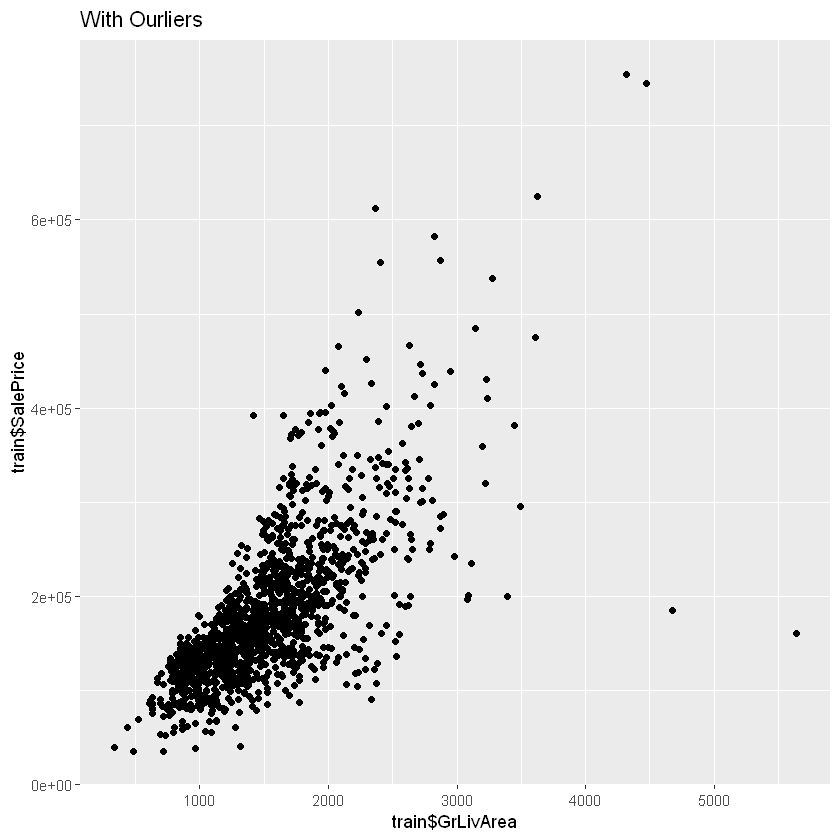

In [23]:
# draw a scatter plot to visualize the outlier
# we want to remove them

# plot sale price againt GrLivArea
suppressPackageStartupMessages(library(ggplot2))
qplot(train$GrLivArea, train$SalePrice, main = "With Ourliers")

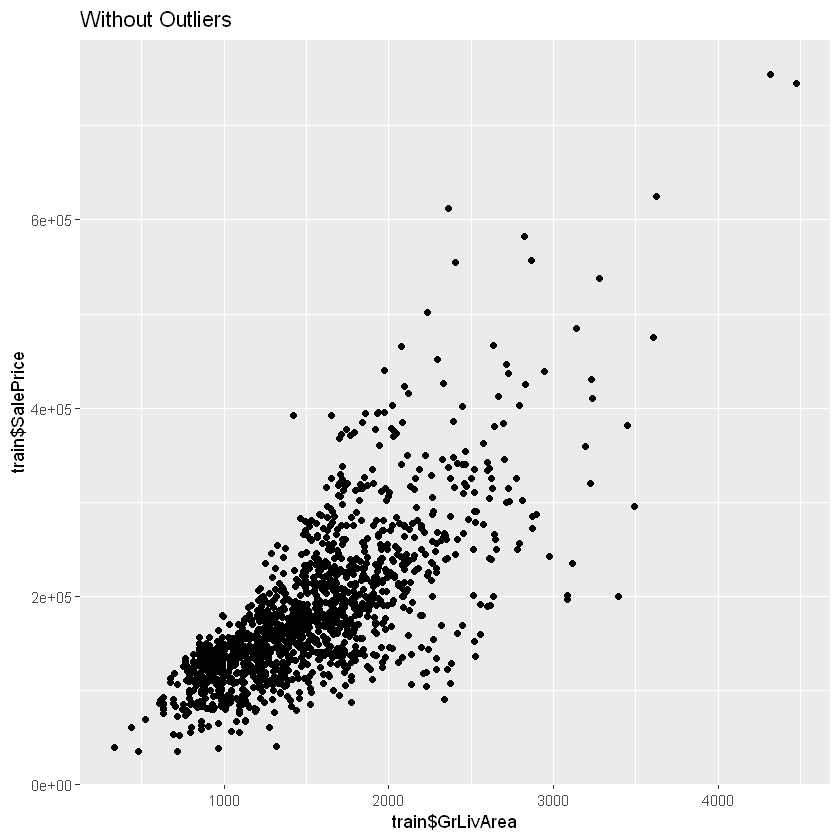

In [24]:
# plot without outlier
# we use negative to mean we want to remove
train = train[-which(train$GrLivArea > 4000 & train$SalePrice < 300000), ]

# check the plot after removing outlier
qplot(train$GrLivArea, train$SalePrice, main = "Without Outliers")

- We want to make the targer normal, so we need to perform transformation by taking log

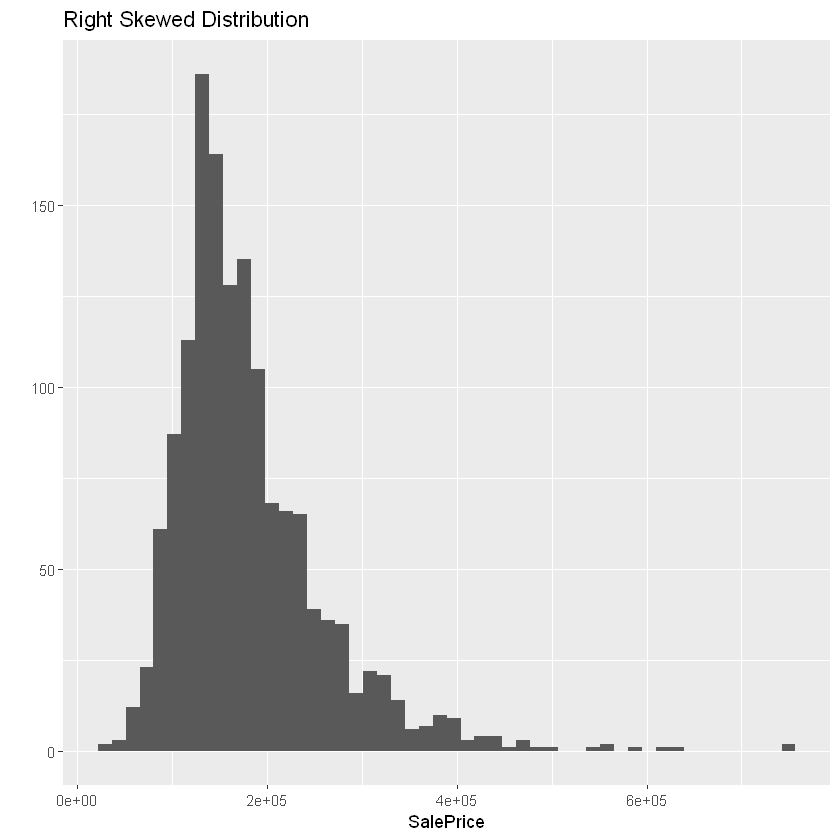

In [25]:
# see the saleprice distribution using histogram
qplot(SalePrice, data = train, bins = 50, main = "Right Skewed Distribution")

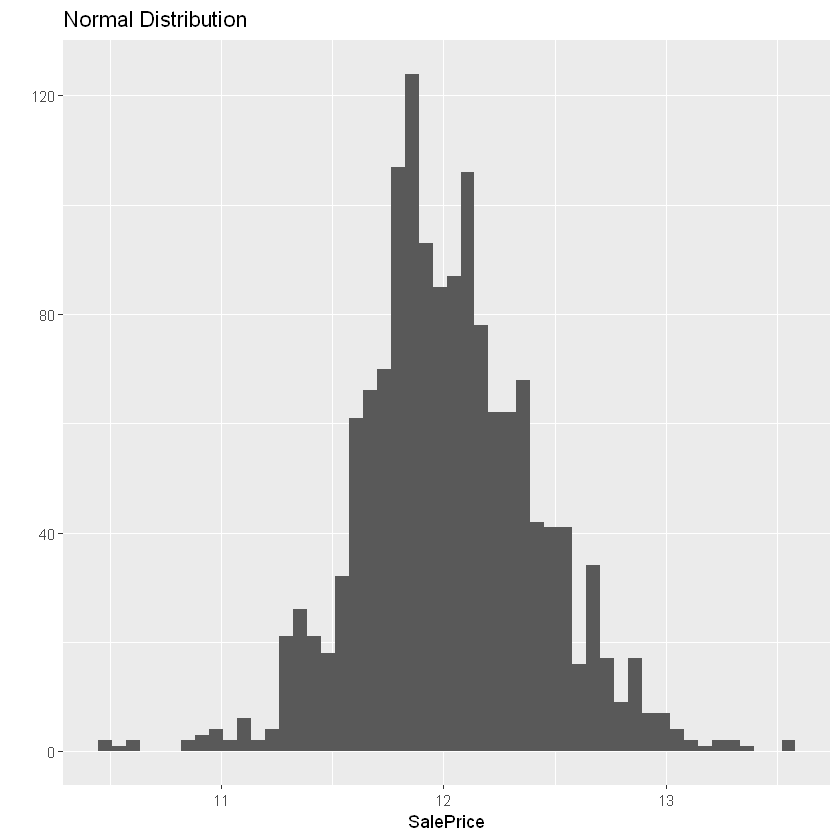

In [46]:
# perform transformation
train$SalePrice = log(train$SalePrice + 1)

# check the distribution again
qplot(SalePrice, data = train, bins = 50, main = "Normal Distribution")

In [47]:
# now combine the train and test set together
combi = rbind(train, test) # using row bind

head(combi,1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<dbl>
1,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2008,WD,Normal,12.2477


In [48]:
# remove the ID column
combi = combi[,-which(names(combi) == "Id")]
head(combi,1)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<dbl>
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,⋯,0,NA,NA,NA,0,2,2008,WD,Normal,12.2477


# EDA

In [31]:
# check the null columns
print(colSums(is.na(combi)))

   MSSubClass      MSZoning   LotFrontage       LotArea        Street 
            0             4           486             0             0 
        Alley      LotShape   LandContour     Utilities     LotConfig 
         2719             0             0             2             0 
    LandSlope  Neighborhood    Condition1    Condition2      BldgType 
            0             0             0             0             0 
   HouseStyle   OverallQual   OverallCond     YearBuilt  YearRemodAdd 
            0             0             0             0             0 
    RoofStyle      RoofMatl   Exterior1st   Exterior2nd    MasVnrType 
            0             0             1             1            24 
   MasVnrArea     ExterQual     ExterCond    Foundation      BsmtQual 
           23             0             0             0            81 
     BsmtCond  BsmtExposure  BsmtFinType1    BsmtFinSF1  BsmtFinType2 
           82            82            79             1            80 
   Bsm

- We can see we do not have a lot of null values
- `PoolQC`, `MiscFeature`, `Alley` and `Fence` have more than 90 percent missing values

## Imputation
- Categorical feature will use none to mean no garage and no basement and so on
- Numerical zero will use 0 to denote the feature that a particular house does not possess

In [49]:
for (x in c("Alley", "PoolQC", "MiscFeature", "Fence", "FireplaceQu", "GarageType", 
    "GarageFinish", "GarageQual", "GarageCond", "BsmtQual", "BsmtCond", 
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "MasVnrType")){
    combi[is.na(combi[,x]), x] = "None"
    }

# group by neighborhood and fill NA with median
temp = aggregate(LotFrontage ~ Neighborhood, combi, median)
temp2 = c()

for (str in combi$Neighborhood[is.na(combi$LotFrontage)]){
    temp2 = c(temp2, which(temp$Neighborhood == str))
    }

combi$LotFrontage[is.na(combi$LotFrontage)] = temp[temp2, 2]

# replace missing data with 0
for (x in c("GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", "BsmtFinSF2", 
    "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath", "MasVnrArea")){
    combi[is.na(combi[,x]), x] = 0
    }

# replace missing mszoning values by `RL`
combi$MSZoning[is.na(combi$MSZoning)] = "RL"

# remove utilities column
combi = combi[,-9]

# replace missing functional value with `Typ`
combi$Functional[is.na(combi$Functional)] = "Typ"

# replace missing electrical value with `SBrkr`
combi$Electrical[is.na(combi$Electrical)] = "SBrkr"

# replace missing kitchenqual value with `TA`
combi$KitchenQual[is.na(combi$KitchenQual)] = "TA"

# replace missing saletype values by `WD`
combi$SaleType[is.na(combi$SaleType)] = "WD"

# replace missing exterior1st values by `VinylSd`
combi$Exterior1st[is.na(combi$Exterior1st)] = "VinylSd"

# replace missing exterior2nd values by `VinylSd`
combi$Exterior2nd[is.na(combi$Exterior2nd)] = "VinylSd"

# check the null columns again
print(colSums(is.na(combi)))

   MSSubClass      MSZoning   LotFrontage       LotArea        Street 
            0             0             0             0             0 
        Alley      LotShape   LandContour     LotConfig     LandSlope 
            0             0             0             0             0 
 Neighborhood    Condition1    Condition2      BldgType    HouseStyle 
            0             0             0             0             0 
  OverallQual   OverallCond     YearBuilt  YearRemodAdd     RoofStyle 
            0             0             0             0             0 
     RoofMatl   Exterior1st   Exterior2nd    MasVnrType    MasVnrArea 
            0             0             0             0             0 
    ExterQual     ExterCond    Foundation      BsmtQual      BsmtCond 
            0             0             0             0             0 
 BsmtExposure  BsmtFinType1    BsmtFinSF1  BsmtFinType2    BsmtFinSF2 
            0             0             0             0             0 
    Bs

In [50]:
# transform numerical variables that are categorical
combi$MSSubClass = as.character(combi$MSSubClass)
combi$OverallCond = as.character(combi$OverallCond)
combi$YrSold = as.character(combi$YrSold)
combi$MoSold = as.character(combi$MoSold)

In [51]:
# perform label encoding
cols = c("FireplaceQu", "BsmtQual", "BsmtCond", "GarageQual", "GarageCond", 
    "ExterQual", "ExterCond", "HeatingQC", "PoolQC", "KitchenQual", "BsmtFinType1", 
    "BsmtFinType2", "Functional", "Fence", "BsmtExposure", "GarageFinish", 
    "LandSlope", "LotShape", "PavedDrive", "Street", "Alley", "CentralAir", 
    "MSSubClass", "OverallCond", "YrSold", "MoSold")

FireplaceQu = c("None", "Po", "Fa", "TA", "Gd", "Ex")
BsmtQual = c("None", "Po", "Fa", "TA", "Gd", "Ex")
BsmtCond = c("None", "Po", "Fa", "TA", "Gd", "Ex")
GarageQual = c("None", "Po", "Fa", "TA", "Gd", "Ex")
GarageCond = c("None", "Po", "Fa", "TA", "Gd", "Ex")
ExterQual = c("Po", "Fa", "TA", "Gd", "Ex")
ExterCond = c("Po", "Fa", "TA", "Gd", "Ex")
HeatingQC = c("Po", "Fa", "TA", "Gd", "Ex")
PoolQC = c("None", "Fa", "TA", "Gd", "Ex")
KitchenQual = c("Po", "Fa", "TA", "Gd", "Ex")
BsmtFinType1 = c("None", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ")
BsmtFinType2 = c("None", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ")
Functional = c("Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ")
Fence = c("None", "MnWw", "GdWo", "MnPrv", "GdPrv")
BsmtExposure = c("None", "No", "Mn", "Av", "Gd")
GarageFinish = c("None", "Unf", "RFn", "Fin")
LandSlope = c("Sev", "Mod", "Gtl")
LotShape = c("IR3", "IR2", "IR1", "Reg")
PavedDrive = c("N", "P", "Y")
Street = c("Pave", "Grvl")
Alley = c("None", "Pave", "Grvl")
MSSubClass = c("20", "30", "40", "45", "50", "60", "70", "75", "80", "85", 
    "90", "120", "150", "160", "180", "190")
OverallCond = NA
MoSold = NA
YrSold = NA
CentralAir = NA
levels = list(FireplaceQu, BsmtQual, BsmtCond, GarageQual, GarageCond, 
    ExterQual, ExterCond, HeatingQC, PoolQC, KitchenQual, BsmtFinType1, 
    BsmtFinType2, Functional, Fence, BsmtExposure, GarageFinish, LandSlope, 
    LotShape, PavedDrive, Street, Alley, CentralAir, MSSubClass, OverallCond, 
    YrSold, MoSold)

i = 1
for (c in cols){
    if (c == "CentralAir" | c == "OverallCond" | c == "YrSold" | c == "MoSold"){
        combi[,c] = as.numeric(factor(combi[,c]))
        } 
    else {
        combi[,c] = as.numeric(factor(combi[,c], levels = levels[[i]]))
        }
}

In [52]:
# add a new feature
combi$TotalSF = combi$TotalBsmtSF + combi$X1stFlrSF + combi$X2ndFlrSF

In [53]:
# dummy categorical features
feature_classes <- sapply(names(combi), function(x){
    class(combi[[x]])
})

numeric_feats <- names(feature_classes[feature_classes != "character"])

# get names of categorical features
categorical_feats <- names(feature_classes[feature_classes == "character"])

# one hot encode categorical features
suppressPackageStartupMessages(library(caret))
dummies <- dummyVars(~., combi[,categorical_feats])
categorical_1_hot <- predict(dummies, combi[categorical_feats])

In [60]:
# fix skewed features
library(moments)
library(MASS)

skewed_feats <- sapply(numeric_feats, function(x) {
    skewness(combi[[x]], na.rm = TRUE)
})

## Keep only features that exceed a threshold (0.75) for skewness
skewed_feats <- skewed_feats[abs(skewed_feats) > 0.75]
skewed_feats <- as.numeric(skewed_feats)

## Transform skewed features with boxcox transformation
for (x in names(skewed_feats)) {
    bc = BoxCoxTrans(combi[[x]], lambda = 0.15)
    combi[[x]] = predict(bc, combi[[x]])
    # combi[[x]] <- log(combi[[x]] + 1)
}

In [61]:
# reconstruct all date with pre-processed data
combi <- cbind(combi[numeric_feats], categorical_1_hot)

# check dimension
print(dim(combi))

[1] 2919  222


# Train Test Split

In [66]:
training <- combi[1:1458, ]
testing <- combi[1459:2917, ]
set.seed(222)
inTrain <- createDataPartition(y = training$SalePrice, p = 0.7, list = FALSE)
Training <- training[inTrain, ]
Validation <- training[-inTrain, ]

# Model Fitting

In [68]:
library(glmnet)
library(Metrics)
set.seed(222)
cv_lasso = cv.glmnet(as.matrix(Training[, -59]), Training[, 59])

## Predictions
preds <- predict(cv_lasso, newx = as.matrix(Validation[, -59]), s = "lambda.min")
rmse(Validation$SalePrice, preds)

ERROR: Error in glmnet(x, y, weights = weights, offset = offset, lambda = lambda, : x has missing values; consider using makeX() to impute them
